This notebook compares the email activities and draft activites of an IETF working group.

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

In [1]:
import bigbang.mailman as mailman
from bigbang.parse import get_date
#from bigbang.functions import *
from bigbang.archive import Archive

from ietfdata.datatracker import *

/home/sb/projects/bigbang-multi/bigbang/config/config.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dictionary = yaml.load(stream)


Also, let's import a number of other dependencies we'll use later.

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os

## Load the HRPC Mailing List

Now let's load the email data for analysis.

In [3]:
urls = ["hrpc"]

archives = [Archive(url,mbox=True) for url in urls]

activities = [arx.get_activity(resolved=False) for arx in archives]
activity = activities[0]

/home/sb/projects/bigbang-multi/bigbang/bigbang/mailman.py:157: UserWarning: No mailing list name found at hrpc
  warnings.warn("No mailing list name found at %s" % url)


## Load IETF Draft Data

Next, we will use the `ietfdata` tracker to look at the frequency of drafts for this working group.

In [4]:
dt = DataTracker()

group = dt.group_from_acronym('hrpc')

def extract_data(doc):
    data = {}
    data['title'] = doc.title
    data['time'] = doc.time
    
    data['person'] = [
        dt.person(doc_author.person)
        for doc_author
        in dt.document_authors(doc)
    ]

    data['affiliation'] = [
        doc_author.affiliation
        for doc_author
        in dt.document_authors(doc)
    ]
    data['group-acronym'] = dt.group(doc.group).acronym
    data['type'] = doc.type.uri

    return data

drafts = dt.documents(group = group,
                      doctype = dt.document_type(
                          DocumentTypeURI("/api/v1/name/doctypename/draft")))

draft_df = pd.DataFrame(data=[extract_data(x) for x in drafts])

We will want to use the data of the drafts. Time resolution is too small.

In [5]:
draft_df['date'] = draft_df['time'].dt.date

## Gender score and tendency measures

This notebook uses the (notably imperfect) method of using first names to guess the gender of each draft author.

In [6]:
from gender_detector import gender_detector as gd
detector = gd.GenderDetector('us')

def gender_score(name):
    """
    Takes a full name and returns a score for the guessed
    gender.
    
    1 - male
    0 - female
    .5 - unknown
    """
    try:
        first_name = name.split(" ")[0]
        guess = detector.guess(first_name)
        score = 0
        if guess == "male":
            return 1.0
        elif guess == "female":
            return 0.0
        else:
            # name does not have confidence to guesss
            return 0.5
    except:
        # Some error, "unknown"
        return .5

## Gender guesses for draft authors

This is used to get a gender guess for each author. This illustrates and tests gender scoring on a small known sample.

In [7]:
draft_df['person'].apply(lambda x : [(p.name[:9], gender_score(p.name))
                                     for p 
                                     in x])

0                 [(Niels ten, 1.0), (Corinne C, 0.0)]
1                 [(Niels ten, 1.0), (Corinne C, 0.0)]
2                 [(Niels ten, 1.0), (Gisela Pe, 0.0)]
3                 [(Niels ten, 1.0), (Amelia An, 0.0)]
4                 [(Stéphane , 0.5), (Niels ten, 1.0)]
5                 [(Gurshabad, 0.5), (Niels ten, 1.0)]
6                                   [(Niels ten, 1.0)]
7    [(Niels ten, 1.0), (=?utf-8?q, 0.5), (Gisela P...
Name: person, dtype: object

The average gender score is used as the 'gender tendency' of the draft.

In [8]:
draft_df['gender tendency'] = draft_df['person'].apply(
    lambda x : sum([gender_score(p.name)
                    for p 
                    in x]) / float(len(x)))

## Gender guesses on mailing list activity

Now to use the gender guesser to track the contributions by differently gendered participants over time.

In [9]:
from bigbang.parse import clean_name

In [10]:
gender_activity = activity.groupby(
    by=lambda x: gender_score(clean_name(x)),
    axis=1).sum().rename({0.0 : "women", 0.5 : "unknown", 1.0 : "men"},
                        axis="columns")

Note that our gender scoring method currently is unable to get a clear guess for a large percentage of the emails!

0.387245.2 percent of emails are from an unknown gender.


Text(0.5, 1.0, 'Total emails sent by guessed gender')

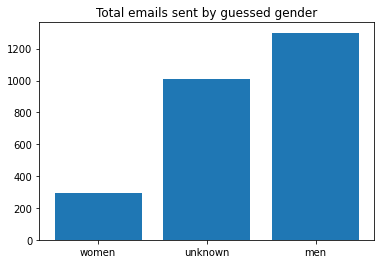

In [11]:
print("%f.2 percent of emails are from an unknown gender." \
      % (gender_activity["unknown"].sum() / gender_activity.sum().sum()))

plt.bar(["women","unknown","men"],gender_activity.sum())
plt.title("Total emails sent by guessed gender")

## Plotting

Some preprocessing is necessary to get the drafts data ready for plotting.

In [12]:
from matplotlib import cm

viridis = cm.get_cmap('viridis')

In [13]:
drafts_per_day = draft_df.groupby('date').count()['title']

In [14]:
draft_gt_per_day = draft_df.groupby('date').mean()['gender tendency'].apply(
    lambda x : viridis(x)
)

For each of the mailing lists we are looking at, plot the rolling average (over `window`) of number of emails sent per day.

Then plot a vertical line with the height of the drafts count and colored by the gender tendency.

In [15]:
window = 100

Text(0.5, 1.0, 'HRPC working group emails and drafts')

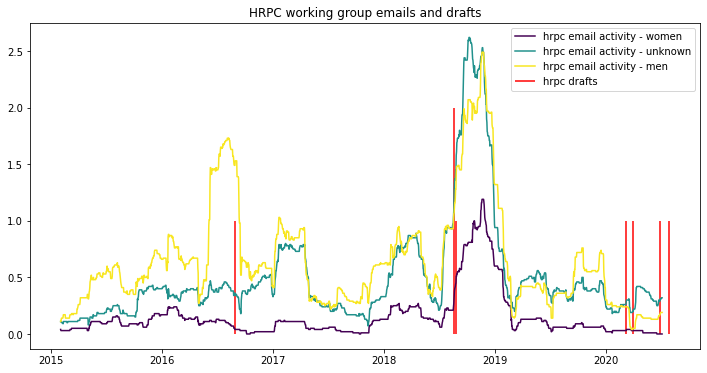

In [16]:
plt.figure(figsize=(12, 6))

for i, gender in enumerate(gender_activity.columns):

    colors = [viridis(0), viridis(.5), viridis(.99)]

    ta = gender_activity[gender]
    rmta = ta.rolling(window).mean()
    rmtadna = rmta.dropna()
    plt.plot_date(np.array(rmtadna.index),
                  np.array(rmtadna.values),
                  color = colors[i],
                  linestyle = '-', marker = None,
                  label='hrpc email activity - %s' % (gender),
                  xdate=True)


vax = plt.vlines(drafts_per_day.index,
           0,
           drafts_per_day,
           colors = 'r', # draft_gt_per_day,
           cmap = 'viridis',
           label='hrpc drafts')

plt.legend()
plt.title("HRPC working group emails and drafts")
#plt.colorbar(vax, label = "more womanly <-- Gender Tendency --> more manly")

#plt.savefig("activites-marked.png")
#plt.show()

### Is gender diversity correlated with draft output?



In [61]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [45]:
drafts_per_ordinal_day = pd.Series({x[0].toordinal(): x[1] for x in drafts_per_day.items()})

In [46]:
drafts_per_ordinal_day

736203    1
736926    2
736933    1
737493    1
737515    1
737605    1
737635    1
dtype: int64

In [47]:
ta.rolling(window).mean()

Date
735531     NaN
735532     NaN
735533     NaN
735534     NaN
735535     NaN
          ... 
737607    0.19
737608    0.19
737609    0.19
737610    0.19
737611    0.19
Name: men, Length: 2081, dtype: float64

In [64]:
garm = np.log1p(gender_activity.rolling(window).mean())

In [65]:
garm['diversity'] = (garm['unknown'] + garm['women']) / garm['men']

In [66]:
garm['drafts'] = drafts_per_ordinal_day
garm['drafts'] = garm['drafts'].fillna(0)

Some variations...

In [67]:
garm_dna = garm.dropna(subset=['drafts'])

In [68]:
garm.corr(method='pearson')

,women,unknown,men,diversity,drafts
women,1.000000,0.877415,0.770341,0.213797,0.010671
unknown,0.877415,1.000000,0.784295,0.303396,0.030767
men,0.770341,0.784295,1.000000,-0.159209,0.012438
diversity,0.213797,0.303396,-0.159209,1.000000,0.062036
drafts,0.010671,0.030767,0.012438,0.062036,1.000000


In [69]:
calculate_pvalues(garm)

,women,unknown,men,diversity,drafts
women,0,0,0,0,0.635
unknown,0,0,0,0,0.1709
men,0,0,0,0,0.58
diversity,0,0,0,0,0.0057
drafts,0.635,0.1709,0.58,0.0057,0
